In [71]:
## Setup and Data Loading
import pandas as pd
import altair as alt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for pandas DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the CSV file into a DataFrame
file_path = 'sales_data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first 5 rows to understand the data structure
print("First 5 rows of the raw data:")
print(df.head())

First 5 rows of the raw data:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

          ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP  \
0    2/24/2003 0:00  Shipped       1         2     2003  Motorcycles    95   
1  05-07-2003 00:00  Shipped       2         5     2003  Motorcycles    95   
2  07-01-2003 00:00  Shipped       3         7     2003  Motorcycles    95   
3    8/25/2003 0:00  Shipped       3         8     2003  Motorcycles    95   
4  10-10-2003 00:00  Shipped       4        10     2003  Motorcycles    95   

  PRODUCTCODE              CUSTOMERNAME             PHONE  \
0    S1

In [73]:
# Print column names and their data types
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non

In [75]:
# Convert `ORDERDATE` to datetime.
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'],format='mixed', dayfirst=True, errors='coerce')

# Aggregate the data on `ORDERDATE` by summing the `SALES`.
df_agg = df.groupby('ORDERDATE')['SALES'].sum().reset_index()

# Display the first 5 rows of the aggregated data
print("First 5 rows of the aggregated data:")
print(df_agg.head())

# Print the column names and their data types of the aggregated data
print("\nAggregated DataFrame Info:")
df_agg.info()

First 5 rows of the aggregated data:
   ORDERDATE     SALES
0 2003-01-04  38217.41
1 2003-01-07  25624.88
2 2003-01-08  31569.43
3 2003-01-12  33666.44
4 2003-01-29  54702.00

Aggregated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ORDERDATE  252 non-null    datetime64[ns]
 1   SALES      252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [77]:
# Create the line chart using Altair
chart = alt.Chart(df_agg).mark_line().encode(
    x=alt.X('ORDERDATE', axis=alt.Axis(title='Date')),
    y=alt.Y('SALES', axis=alt.Axis(title='Total Sales')),
    tooltip=['ORDERDATE', 'SALES']
).properties(
    # Set the title of the plot
    title='Total Sales Over Time'
).interactive()

chart.save('total_sales_over_time_line_chart.json')

chart

alt.Chart(...)

In [79]:
# Prepare the DataFrame for Prophet
df_prophet = df_agg.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})

# Instantiate the Prophet model
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False  # Set to True if sales have strong day-to-day patterns
)

# Fit the model
model.fit(df_prophet)

# Create future DataFrame — 365 days beyond the latest date in df_prophet
future = model.make_future_dataframe(periods=365)

# Predict future sales
forecast = model.predict(future)

# Display the forecast
print("First 5 rows of the sales forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head().to_markdown(index=False, numalign="left", stralign="left"))

18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing


First 5 rows of the sales forecast:
| ds                  | yhat    | yhat_lower   | yhat_upper   |
|:--------------------|:--------|:-------------|:-------------|
| 2003-01-04 00:00:00 | 34736.2 | 5036.01      | 66409.4      |
| 2003-01-07 00:00:00 | 45365.7 | 16058.7      | 77206.9      |
| 2003-01-08 00:00:00 | 49242.3 | 21404.1      | 80519.1      |
| 2003-01-12 00:00:00 | 50393.1 | 20378.6      | 79921.1      |
| 2003-01-29 00:00:00 | 40729.2 | 10690.6      | 72028.6      |


In [80]:
#  Forecast DataFrame info
print("\nForecast DataFrame Info:")
forecast.info()


Forecast DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          617 non-null    datetime64[ns]
 1   trend                       617 non-null    float64       
 2   yhat_lower                  617 non-null    float64       
 3   yhat_upper                  617 non-null    float64       
 4   trend_lower                 617 non-null    float64       
 5   trend_upper                 617 non-null    float64       
 6   multiplicative_terms        617 non-null    float64       
 7   multiplicative_terms_lower  617 non-null    float64       
 8   multiplicative_terms_upper  617 non-null    float64       
 9   weekly                      617 non-null    float64       
 10  weekly_lower                617 non-null    float64       
 11  weekly_upper                617 

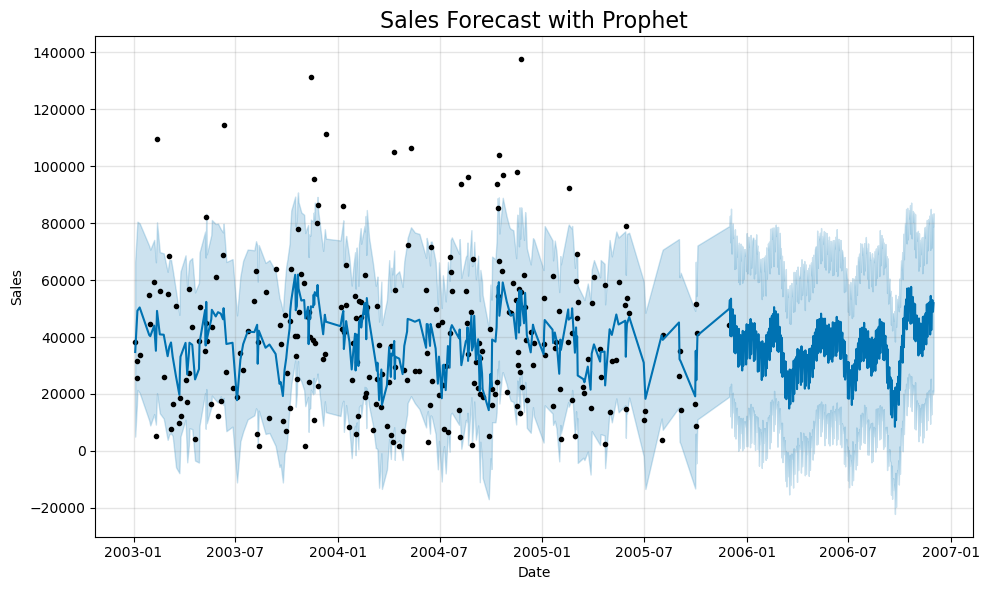

In [82]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Sales Forecast with Prophet', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.savefig("sales_forecast.png")
plt.show()

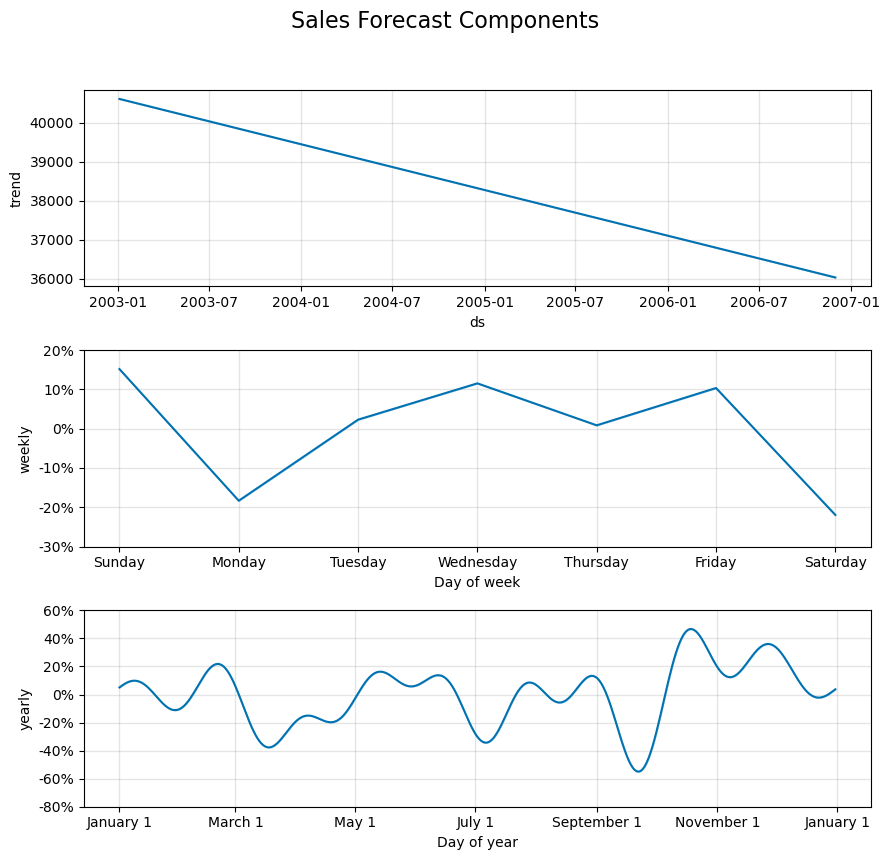

In [84]:
# Plot the forecast components 
fig2 = model.plot_components(forecast)
plt.suptitle('Sales Forecast Components', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.savefig("forecast_components.png")
plt.show()

In [86]:
# Create a copy of the aggregated DataFrame for regression analysis
df_regression = df_agg.copy()

# Add a numerical representation of the date
df_regression['ORDERDATE_ordinal'] = df_regression['ORDERDATE'].apply(lambda date: date.toordinal())

# Create lag features for sales
lags = 7
for i in range(1, lags + 1):
    df_regression[f'lag_{i}'] = df_regression['SALES'].shift(i)

# Drop rows with NaN values introduced by lagging
df_regression.dropna(inplace=True)

print(f"First 5 rows of the DataFrame with lag features (lags={lags}):")
print(df_regression.head().to_markdown(index=False, numalign="left", stralign="left"))

First 5 rows of the DataFrame with lag features (lags=7):
| ORDERDATE           | SALES   | ORDERDATE_ordinal   | lag_1   | lag_2   | lag_3   | lag_4   | lag_5   | lag_6   | lag_7   |
|:--------------------|:--------|:--------------------|:--------|:--------|:--------|:--------|:--------|:--------|:--------|
| 2003-02-10 00:00:00 | 5142.15 | 731256              | 59280.5 | 44622   | 54702   | 33666.4 | 31569.4 | 25624.9 | 38217.4 |
| 2003-02-12 00:00:00 | 109432  | 731258              | 5142.15 | 59280.5 | 44622   | 54702   | 33666.4 | 31569.4 | 25624.9 |
| 2003-02-17 00:00:00 | 56181.3 | 731263              | 109432  | 5142.15 | 59280.5 | 44622   | 54702   | 33666.4 | 31569.4 |
| 2003-02-24 00:00:00 | 25783.8 | 731270              | 56181.3 | 109432  | 5142.15 | 59280.5 | 44622   | 54702   | 33666.4 |
| 2003-03-03 00:00:00 | 55245   | 731277              | 25783.8 | 56181.3 | 109432  | 5142.15 | 59280.5 | 44622   | 54702   |


In [87]:
print("\nDataFrame with Lag Features Info:")
df_regression.info()


DataFrame with Lag Features Info:
<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 7 to 251
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ORDERDATE          245 non-null    datetime64[ns]
 1   SALES              245 non-null    float64       
 2   ORDERDATE_ordinal  245 non-null    int64         
 3   lag_1              245 non-null    float64       
 4   lag_2              245 non-null    float64       
 5   lag_3              245 non-null    float64       
 6   lag_4              245 non-null    float64       
 7   lag_5              245 non-null    float64       
 8   lag_6              245 non-null    float64       
 9   lag_7              245 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 21.1 KB


In [88]:
# Define features (X) and target (y)
features = [f'lag_{i}' for i in range(1, lags + 1)] + ['ORDERDATE_ordinal']
X = df_regression[features]
y = df_regression['SALES']

In [89]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [91]:
# Make predictions on the test set
y_pred = linear_model.predict(X_test)
y_pred

array([35210.08258602, 40250.60172381, 38939.22555189, 33322.59900314,
       39852.51399976, 45395.99385263, 52614.69332262, 40787.9648289 ,
       39700.92302129, 40291.17927769, 38753.93202439, 26796.07839396,
       45688.45988924, 42804.11084244, 38472.2903614 , 39887.61674506,
       42770.1676401 , 37838.97436765, 36033.1001649 , 37034.13636384,
       50727.80702653, 37055.0822731 , 33698.63032347, 36393.14335657,
       39190.15945551, 43054.00369298, 33396.06209311, 38787.55222998,
       34587.28669563, 36310.768787  , 36140.46659646, 35829.66593751,
       43145.5149276 , 43353.63918636, 37152.80682763, 30083.5617144 ,
       36613.48884099, 35785.45439288, 30783.1805866 , 28616.29376587,
       42542.47348912, 44963.8187549 , 33803.92112364, 31349.85640411,
       37813.50659238, 43381.17559073, 31347.00219015, 36174.08759706,
       39362.42867204])

In [92]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R^2) Score: {r2:.2f}")

Linear Regression Model Performance:
Mean Squared Error (MSE): 928137921.57
R-squared (R^2) Score: -0.07


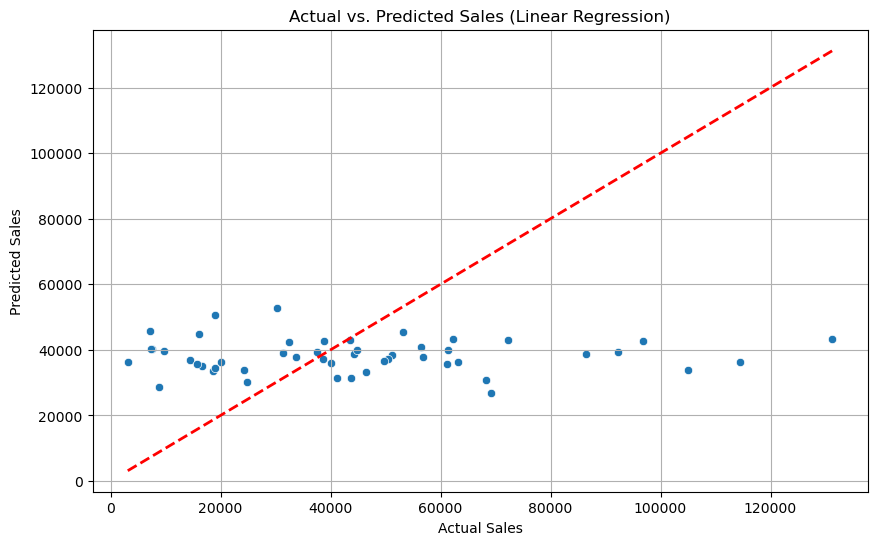

In [94]:
# Visualize actual vs. predicted sales for the regression model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
plt.title('Actual vs. Predicted Sales (Linear Regression)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.savefig("actual_vs_predicted_sales_regression.png")
plt.show()